In [1]:
import random

import torch
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm

In [2]:
# Define a function to load the arrays from the file
def load_arrays_from_file(filename):
    with open(filename, 'r') as file:
        data = file.read().strip().split('\n')  # Read file and split by newline
    
    arrays = []
    for line in data:
        # Convert the string of numbers into a numpy array
        array = np.array([int(x) for x in line.split()])
        arrays.append(array)
    
    return arrays

# Load the arrays
arrays = load_arrays_from_file('hopfield-clean.seq')

In [3]:
len(arrays)

360

In [4]:
# Define the array
# data = np.array([
#     -1, 1, 1, 1, 1, 1, 1, -1, 1, -1, -1, -1, 
#     -1, -1, -1, 1, 1, -1, -1, -1, -1, -1, -1, 1,
#     1, -1, -1, -1, -1, -1, -1, 1, 1, -1, -1, -1, 
#     -1, -1, -1, 1, 1, -1, -1, -1, -1, -1, -1, 1,
#     1, -1, -1, -1, -1, -1, -1, 1, 1, -1, -1, -1, 
#     -1, -1, -1, 1, 1, -1, -1, -1, -1, -1, -1, 1,
#     1, -1, -1, -1, -1, -1, -1, 1, 1, -1, -1, -1, 
#     -1, -1, -1, 1, -1, 1, 1, 1, 1, 1, 1, -1
# ])

In [5]:
def print_flat_array_as_num(arr):
    # Reshape to 8x12
    sq = arr.reshape(12, 8)

    # Create a colormap for -1 as white and 1 as black
    cmap = plt.cm.gray
    norm = plt.Normalize(vmin=-1, vmax=1)

    # Plot the figure
    plt.figure(figsize=(6, 4))
    plt.imshow(sq, cmap=plt.cm.gray_r, norm=norm)
    plt.xticks([])  # No ticks on x axis
    plt.yticks([])  # No ticks on y axis
    plt.grid(False)
    plt.show()

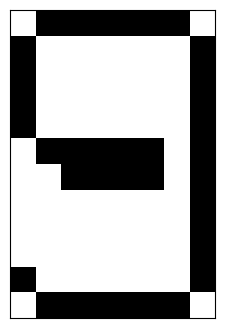

In [6]:
a1 = random.choice(arrays)
print_flat_array_as_num(a1)

In [25]:
# return weights matrix
def naive_train(data):
    M, N = data.shape
    print("data shape", M, N)
    
    W = np.zeros((M, M))

    for k in range(N):
        W += (1/N) * np.outer(data[:, k], data[:, k])

    # Zeroing the diagonal
    np.fill_diagonal(W, 0)
    return W

In [8]:
# This function approximates the behavior of the MATLAB satlins function 
# (saturating linear transfer) using np.clip().
def satlins(x):
    return np.clip(x, 0, 1)

def predict(data, W):
    CY = []

    M, N = data.shape
    # Iterating over each column of t
    for k in range(N):
        u = data[:, k]
        while np.linalg.norm(satlins(W @ u) - u) > 0:
            u = satlins(W @ u)
        CY.append(u)

    CY = np.array(CY).T  # Convert list of arrays to 2D array
    return CY

In [9]:
def plot_weights(W):
    plt.figure(figsize=(6, 5))
    w_mat = plt.imshow(W, cmap=cm.coolwarm)
    plt.colorbar(w_mat)
    plt.title("Network Weights")
    plt.tight_layout()
    plt.show()

In [26]:
t = np.array(arrays[0:50]).T
S, Q = t.shape
W = naive_train(t)

p = predict(t, W)

data shape 96 50


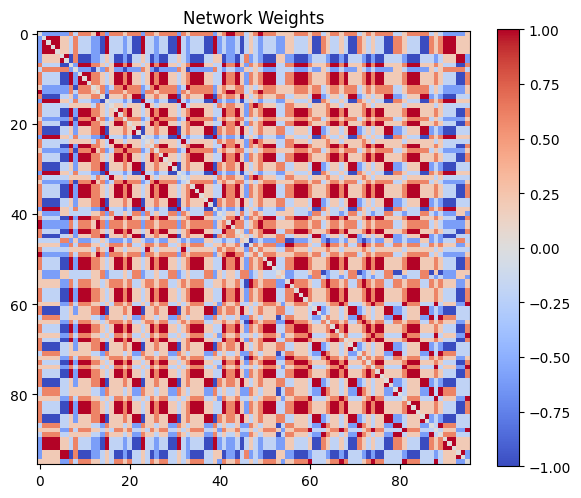

In [27]:
plot_weights(W)


In [12]:
space = 2
n_copies = 30
n_classes = 12
digit_height = 12
digit_width = 8
alld = np.zeros(
    (n_classes * (digit_height + space) - space, 
    n_copies * (digit_width + space) - space))
print(alld.shape)

def print_full_grid(arr):
    M, N = arr.shape
    for p in range(N):
        otv = np.zeros((digit_height, digit_width))
        ot = arr[:, p]
        for n in range(M):
            otv[n // digit_width, n % digit_width] = ot[n]

        x = (p % n_copies) * space
        y = (p // n_copies) * space
        a = slice(
            (p // n_copies) * digit_height + y, 
            (p // n_copies + 1) * digit_height + y)
        b = slice(
            x + (p % n_copies) * digit_width, 
            x + (p % n_copies + 1) * digit_width)
        alld[a, b] = otv

    # Plotting the results
    fig, ax = plt.subplots(figsize=(15, 15))
    # cmap = plt.cm.get_cmap('gray')
    ax.imshow(alld, cmap=plt.cm.gray_r)
    ax.grid(True)

    plt.show()

(166, 298)


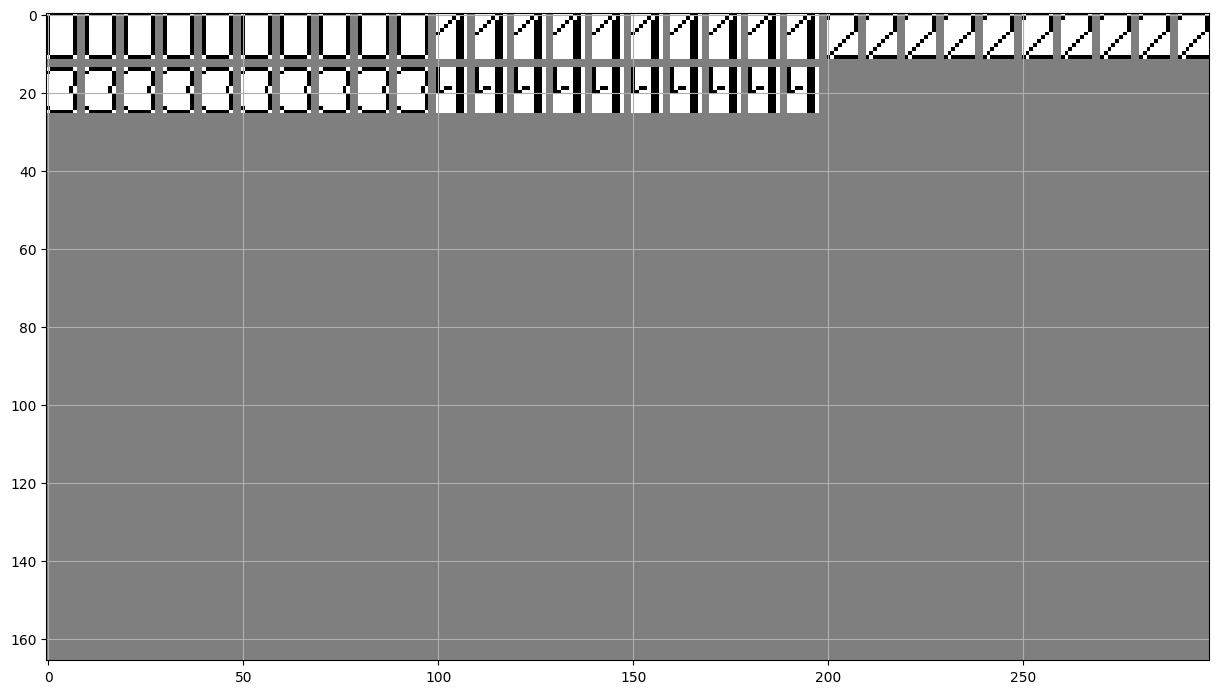

In [13]:
print_full_grid(t)

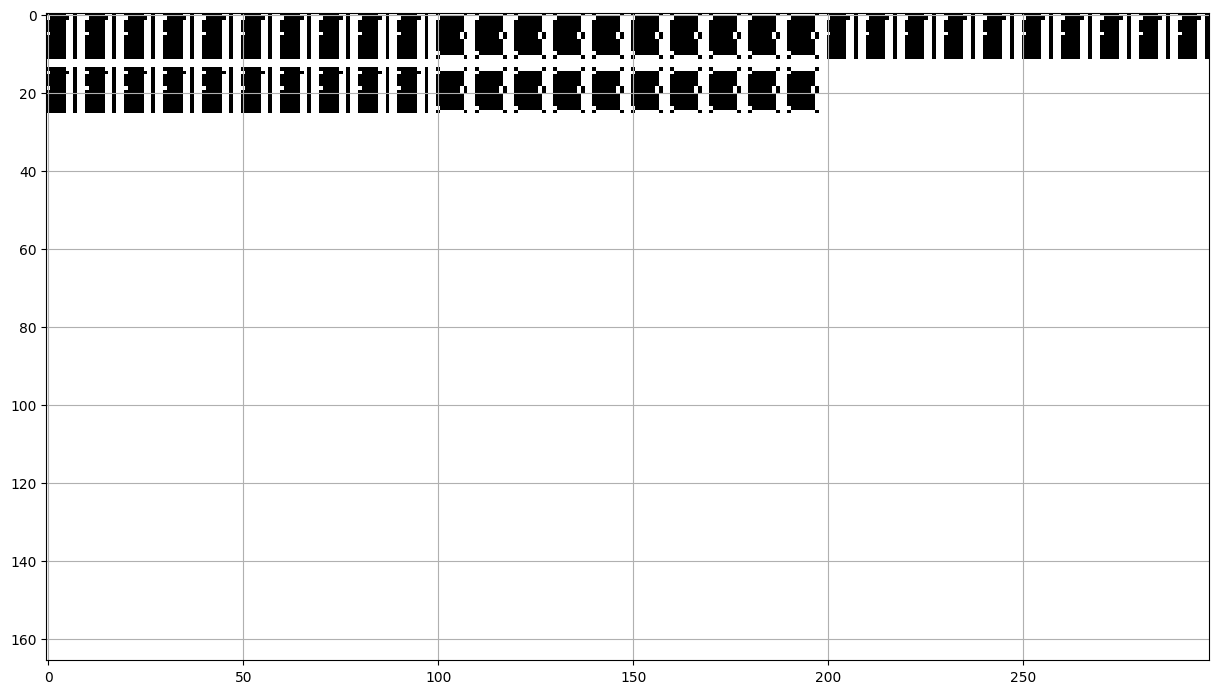

In [14]:
print_full_grid(p)

In [28]:
# https://github.com/takyamamoto/Hopfield-Network/tree/master

import matplotlib.cm as cm

class HopfieldNetwork(object):      
    def train_weights(self, train_data):
        print("Start to train weights...")
        num_data =  len(train_data)
        self.num_neuron = train_data[0].shape[0]
        
        # initialize weights
        W = np.zeros((self.num_neuron, self.num_neuron))
        rho = np.sum([np.sum(t) for t in train_data]) / (num_data*self.num_neuron)
        print("rho", rho)
        
        # Hebb rule
        for i in range(num_data):
            t = train_data[i] - rho
            W += np.outer(t, t)
        
        # Make diagonal element of W into 0
        diagW = np.diag(np.diag(W))
        W = W - diagW
        W /= num_data
        
        self.W = W 
    
    def predict(self, data, num_iter=20, threshold=0, asyn=False):
        print("Start to predict...")
        self.num_iter = num_iter
        self.threshold = threshold
        self.asyn = asyn
        
        # Copy to avoid call by reference 
        copied_data = np.copy(data)
        
        # Define predict list
        predicted = []
        for i in range(len(data)):
            predicted.append(self._run(copied_data[i]))
        return predicted
    
    def _run(self, init_s):
        if self.asyn==False:
            """
            Synchronous update
            """
            # Compute initial state energy
            s = init_s

            e = self.energy(s)
            
            # Iteration
            for i in range(self.num_iter):
                # Update s
                s = np.sign(self.W @ s - self.threshold)
                # Compute new state energy
                e_new = self.energy(s)
                
                # s is converged
                if e == e_new:
                    return s
                # Update energy
                e = e_new
            return s
        else:
            """
            Asynchronous update
            """
            # Compute initial state energy
            s = init_s
            e = self.energy(s)
            
            # Iteration
            for i in range(self.num_iter):
                for j in range(100):
                    # Select random neuron
                    idx = np.random.randint(0, self.num_neuron) 
                    # Update s
                    s[idx] = np.sign(self.W[idx].T @ s - self.threshold)
                
                # Compute new state energy
                e_new = self.energy(s)
                
                # s is converged
                if e == e_new:
                    return s
                # Update energy
                e = e_new
            return s
    
    
    def energy(self, s):
        return -0.5 * s @ self.W @ s + np.sum(s * self.threshold)

    def plot_weights(self):
        plt.figure(figsize=(6, 5))
        w_mat = plt.imshow(self.W, cmap=cm.coolwarm)
        plt.colorbar(w_mat)
        plt.title("Network Weights")
        plt.tight_layout()
        plt.savefig("weights.png")
        plt.show()
        

In [29]:
model = HopfieldNetwork()
model.train_weights(arrays)

Start to train weights...
rho -0.34375


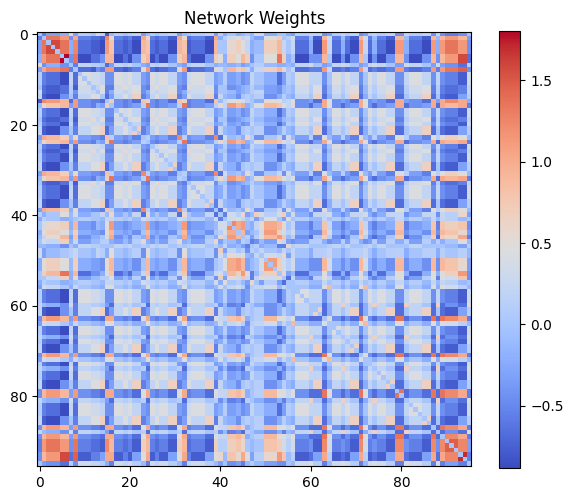

In [17]:
model.plot_weights()

In [18]:
pp = model.predict(arrays[0:50])

Start to predict...


In [19]:
ppp = np.array(pp).T

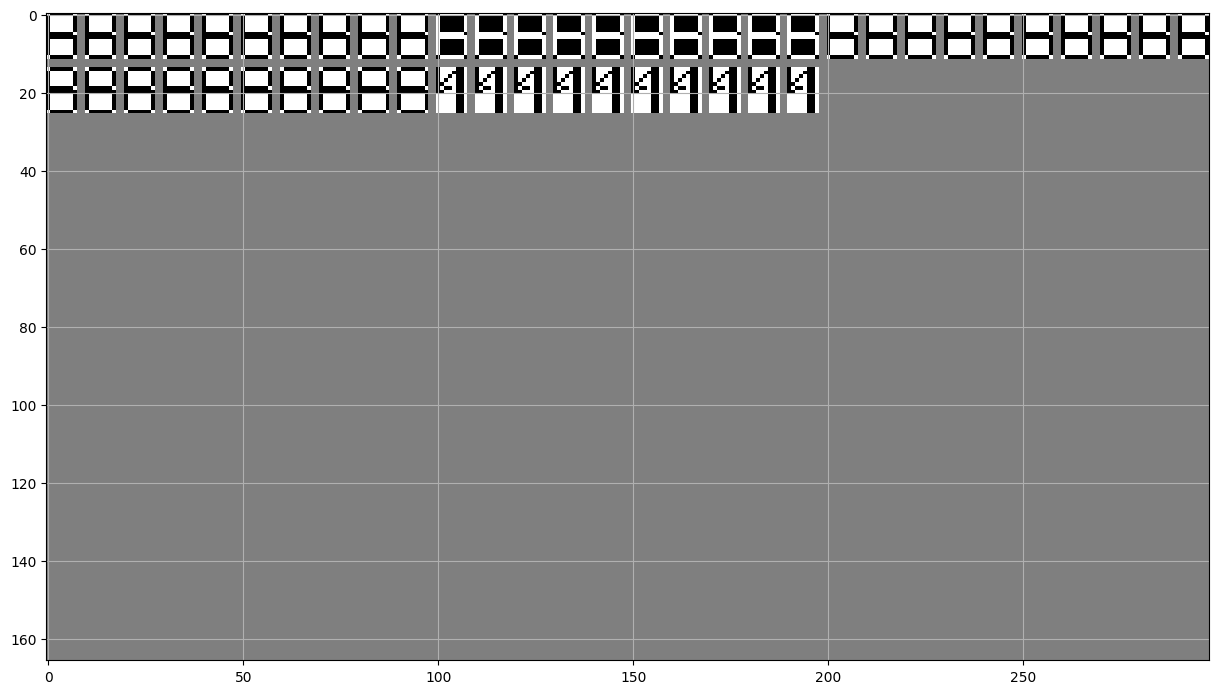

In [20]:
print_full_grid(ppp)